In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import zipfile
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
np.random.seed(2023)

# Undersampling R
path = '/content/drive/MyDrive/capstone/Dataset#1/train/R'# You can provide the path here
n =  200 # Number of random images to be removed
img_names = os.listdir(path)  # Get image names in folder
img_names = random.sample(img_names, n)  # Pick 2500 random images
for image in img_names:  # Go over each image name to be deleted
    f = os.path.join(path, image)  # Create valid path to image
    os.remove(f)  # Remove the image


Number of images in the train set :  11034
Number of images in the test set ;  1176


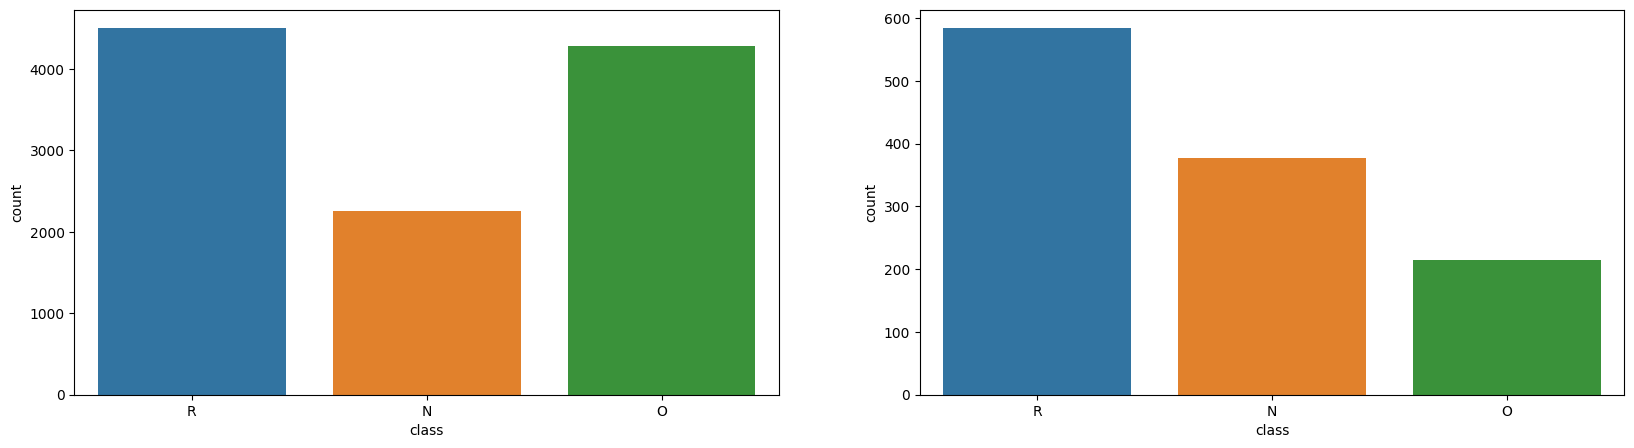

In [ ]:
root_path = '/content/drive/MyDrive/capstone/Dataset#1/'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = '/content/drive/MyDrive/capstone/Dataset#1/train/' #one more seg_train folder within
seg_test_folders = '/content/drive/MyDrive/capstone/Dataset#1/test/'
#seg_pred_folders = '../input/intel-image-classification/seg_pred/seg_pred/'
quantity_tr = {}
quantity_te = {}
for folder in os.listdir(seg_train_folders):
    quantity_tr[folder] = len(os.listdir(seg_train_folders+folder))

for folder in os.listdir(seg_test_folders):
    quantity_te[folder] = len(os.listdir(seg_test_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set ; ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
#print("Number of images in prediction set : ",number_of_images_in_prediction_set)

plt.show()

In [ ]:
quantity_train.head()

,class,count
0,R,4501
1,N,2251
2,O,4282


In [ ]:
quantity_test.head()

,class,count
0,R,584
1,N,377
2,O,215


In [ ]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:
    hist_df = pd.DataFrame(history.history)

    # save to json:
    hist_json_file = model_name+'_history.json'
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv:
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']


    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()

def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()

def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [ ]:
train_datagen = ImageDataGenerator( rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance.
train_generator = train_datagen.flow_from_directory(seg_train_folders,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(seg_test_folders, shuffle=True, batch_size=1, class_mode='categorical', target_size=(150, 150))

Found 11029 images belonging to 3 classes.
Found 1176 images belonging to 3 classes.


In [ ]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'N': 0, 'O': 1, 'R': 2}
{0: 'N', 1: 'O', 2: 'R'}


In [ ]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(seg_train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(seg_train_folders)):
        image_ids = os.listdir(os.path.join(seg_train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:

            display = plt.imread(os.path.join(seg_train_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

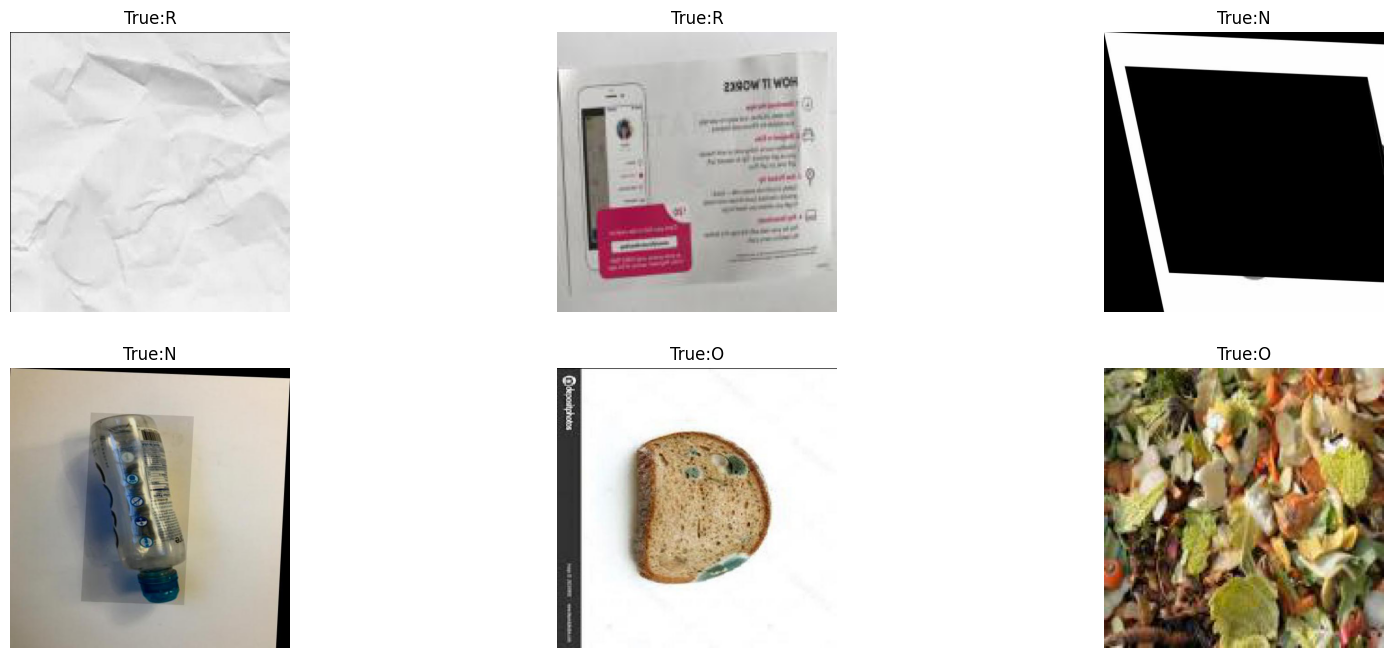

In [ ]:
show_few_images(2)

In [ ]:
tf.keras.backend.clear_session()

# epoch config
benchmark_epoch = 20
vgg_epoch = 20
resnet_epoch = 20
inception_epoch = 20

In [ ]:
#random architecture
benchmark_model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

benchmark_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
a = []
while(1):
    a.append(‘1’)

In [ ]:
filepath = "bench_mark_-model-{epoch:02d}-{val_acc:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = benchmark_model.fit(train_generator,epochs=benchmark_epoch, verbose=1, validation_data = validation_generator,callbacks=[reduce_lr,early_stopping,checkpoint])

benchmark_model.save(filepath)
#do_history_stuff(history, 'benchmark_model')


Epoch 1/20
141/304 [============>.................] - ETA: 15:20 - loss: 0.8461 - acc: 0.6024

KeyboardInterrupt: ignored

In [ ]:
benchmark_model.save("/home/benchmark/")

In [ ]:
!zip -r /home/benchmark.zip /home/benchmark

In [ ]:
from google.colab import files
files.download('/home/benchmark.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(150,150,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(3, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
number_of_epochs = vgg_epoch
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)

#do_history_stuff(vgg16_history, 'vgg16_model')

58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/30
345/345 [==============================] - ETA: 0s - loss: 0.6337 - acc: 0.7251 
Epoch 1: val_acc improved from -inf to 0.69388, saving model to vgg_16_-saved-model-01-acc-0.69.hdf5
345/345 [==============================] - 6133s 18s/step - loss: 0.6337 - acc: 0.7251 - val_loss: 0.6501 - val_acc: 0.6939
Epoch 2/30
345/345 [==============================] - ETA: 0s - loss: 0.5188 - acc: 0.7830
Epoch 2: val_acc improved from 0.69388 to 0.71429, saving model to vgg_16_-saved-model-02-acc-0.71.hdf5
345/345 [==============================] - 154s 445ms/step - loss: 0.5188 - acc: 0.7830 - val_loss: 0.6378 - val_acc: 0.7143
Epoch 3/30
345/345 [==============================] - ETA: 0s - loss: 0.4873 - acc: 0.7956
Epoch 3: val_acc improved from 0.71429 to 0.72959, saving model to vgg_16_-saved-model-03-acc-0.73.hdf5
345/345 [==============================] - 154s 447ms/step - loss: 0.4873 - acc: 0.7956 - val_loss: 0.6

In [ ]:
vgg16_final_model.save("/home/VGG/")

In [ ]:
!zip -r /home/VGG.zip/home/VGG


zip error: Nothing to do! (/home/VGG.zip/home/VGG.zip)


In [ ]:
from google.colab import files
files.download('/home/VGG.zip')

FileNotFoundError: ignored

In [ ]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3), classes=6)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(3,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)

#do_history_stuff(resnet50_history, 'resnet50_model')

94765736/94765736 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20


In [ ]:
resnet50_x_final_model.save("/home/resnet/")

In [ ]:
!zip -r /home/resnet.zip /home/resnet

  adding: home/resnet/ (stored 0%)
  adding: home/resnet/variables/ (stored 0%)
  adding: home/resnet/variables/variables.index (deflated 82%)
  adding: home/resnet/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: home/resnet/assets/ (stored 0%)
  adding: home/resnet/keras_metadata.pb (deflated 96%)
  adding: home/resnet/fingerprint.pb (stored 0%)
  adding: home/resnet/saved_model.pb (deflated 92%)


In [ ]:
from google.colab import files
files.download('/home/resnet.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# this could also be the output a different Keras model or layer

InceptionV3_model = InceptionV3(input_shape=(150,150,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(3, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

number_of_epochs = inception_epoch
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data = validation_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

#do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)

In [ ]:
InceptionV3_x_final_model.save("/home/inception/")

In [ ]:
!zip -r /home/inception.zip /home/inception

  adding: home/inception/ (stored 0%)
  adding: home/inception/variables/ (stored 0%)
  adding: home/inception/variables/variables.index (deflated 79%)
  adding: home/inception/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: home/inception/assets/ (stored 0%)
  adding: home/inception/keras_metadata.pb (deflated 96%)
  adding: home/inception/fingerprint.pb (stored 0%)
  adding: home/inception/saved_model.pb (deflated 92%)


In [ ]:
from google.colab import files
files.download('/home/inception.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
resnet_best_model = keras.models.load_model('/content/drive/MyDrive/capstone/resnet/home/resnet')
#vgg_best_model = keras.models.load_model('/content/drive/MyDrive/Capstone_Project/VGG')
inception_best_model = keras.models.load_model('/content/drive/MyDrive/capstone/inception/home/inception')
benchmark_model = keras.models.load_model('/content/drive/MyDrive/capstone/benchmark//home/benchmark')

In [ ]:
#vgg_best_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/vgg_16_-saved-model-15-acc-0.88.hdf5')
#resnet_best_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/resnet50-saved-model-11-val_acc-0.92.hdf5')
#inception_best_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/inceptionv3_-saved-model-03-loss-0.22.hdf5')
#benchmark_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/bench_mark_-model-18-0.79.hdf5')
#vgg_best_model = vgg16_final_model
resnet_best_model = resnet50_x_final_model
inception_best_model = InceptionV3_x_final_model

In [ ]:

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
#combined_model_pred = []
#vgg_pred = []
resnet_pred = []
inception_pred = []
benchmark_model_pred = []
for folder in os.listdir(seg_test_folders):

    test_image_ids = os.listdir(os.path.join(seg_test_folders,folder))

    for image_id in test_image_ids[:int(len(test_image_ids))]:

        path = os.path.join(seg_test_folders,folder,image_id)

        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        img_normalized = img/255
        #vgg
        #vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        #vgg_pred.append(vgg16_image_prediction)

        #resnet50
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_50_image_prediction)

        #Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)

        #benchmark
        benchmark_model_prediction = np.argmax(benchmark_model.predict(np.array([img_normalized])))
        benchmark_model_pred.append(benchmark_model_prediction)

        #giving vgg16 high priority if they all predict something different
        #image_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])
        #combined_model_pred.append(image_prediction)

1/1 [==============================] - 0s 21ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):

    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)

    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

    print(classification_report(true_value, model_pred, target_names = list(classes)))


Model Accuracy 0.3465346534653465
              precision    recall  f1-score   support

           N       0.28      0.66      0.39        96
           O       0.00      0.00      0.00        70
           R       0.57      0.31      0.40       137

    accuracy                           0.35       303
   macro avg       0.28      0.32      0.26       303
weighted avg       0.35      0.35      0.31       303



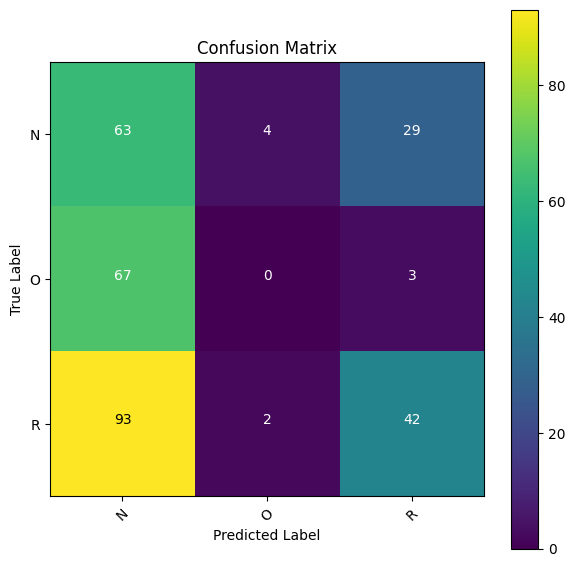

In [ ]:
#benchmark model
clf_report(true_value, benchmark_model_pred)

In [ ]:
#combined vote
combined_model_pred = [ c[0] for c in combined_model_pred]
clf_report(true_value, combined_model_pred)

NameError: ignored

Model Accuracy 0.5841584158415841
              precision    recall  f1-score   support

           N       0.47      0.76      0.58        96
           O       0.50      0.07      0.12        70
           R       0.71      0.72      0.72       137

    accuracy                           0.58       303
   macro avg       0.56      0.52      0.48       303
weighted avg       0.59      0.58      0.54       303



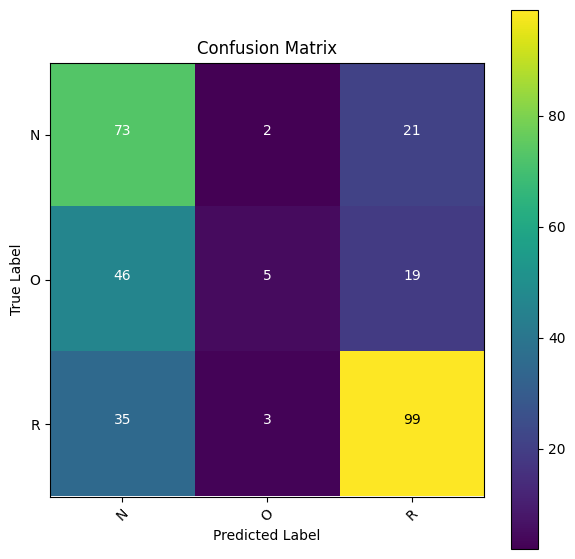

In [ ]:
# Resnet50 model classification report
clf_report(true_value, resnet_pred)

Model Accuracy 0.7293729372937293
              precision    recall  f1-score   support

           N       0.60      0.76      0.67        96
           O       0.85      0.59      0.69        70
           R       0.80      0.78      0.79       137

    accuracy                           0.73       303
   macro avg       0.75      0.71      0.72       303
weighted avg       0.75      0.73      0.73       303



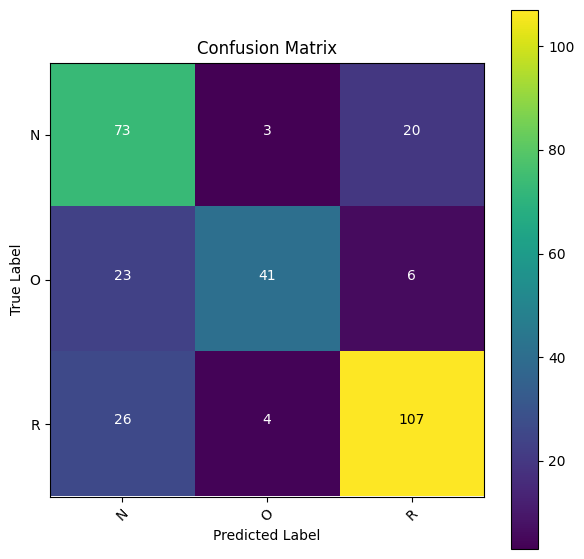

In [ ]:
# Inception model classification report
clf_report(true_value, inception_pred)

In [ ]:
## convert and save a tflite model
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model('inception#fix.zip')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

#if you want to save the TF Lite model use below steps or else skip
tflite_model_files = pathlib.Path('/tmp/pretrainedmodel.tflite')
tflite_model_file.write_bytes(tflite_model)

OSError: ignored